# Reading in and preparing the dataset

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gspread as gs
import gspread_dataframe as gd
import copy
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2,read_consesus,read_fre
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,8.0,88.77
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,89.99
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN,6.0,99.77


In [3]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [4]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 3 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

tss_df.shape

Top 5 cols with missing data per col:
tss_pac_9     3
tss_qua_2     3
tss_rep_9     3
tss_coh_2     3
tss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
203     0
209     0
dtype: int64


(303, 95)

# Scale Construction (EFA)

## Preliminary Data Checks

In [5]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations than I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.821918
std      10.588703
min      27.000000
25%      43.000000
50%      51.000000
75%      60.000000
max      69.000000
dtype: float64


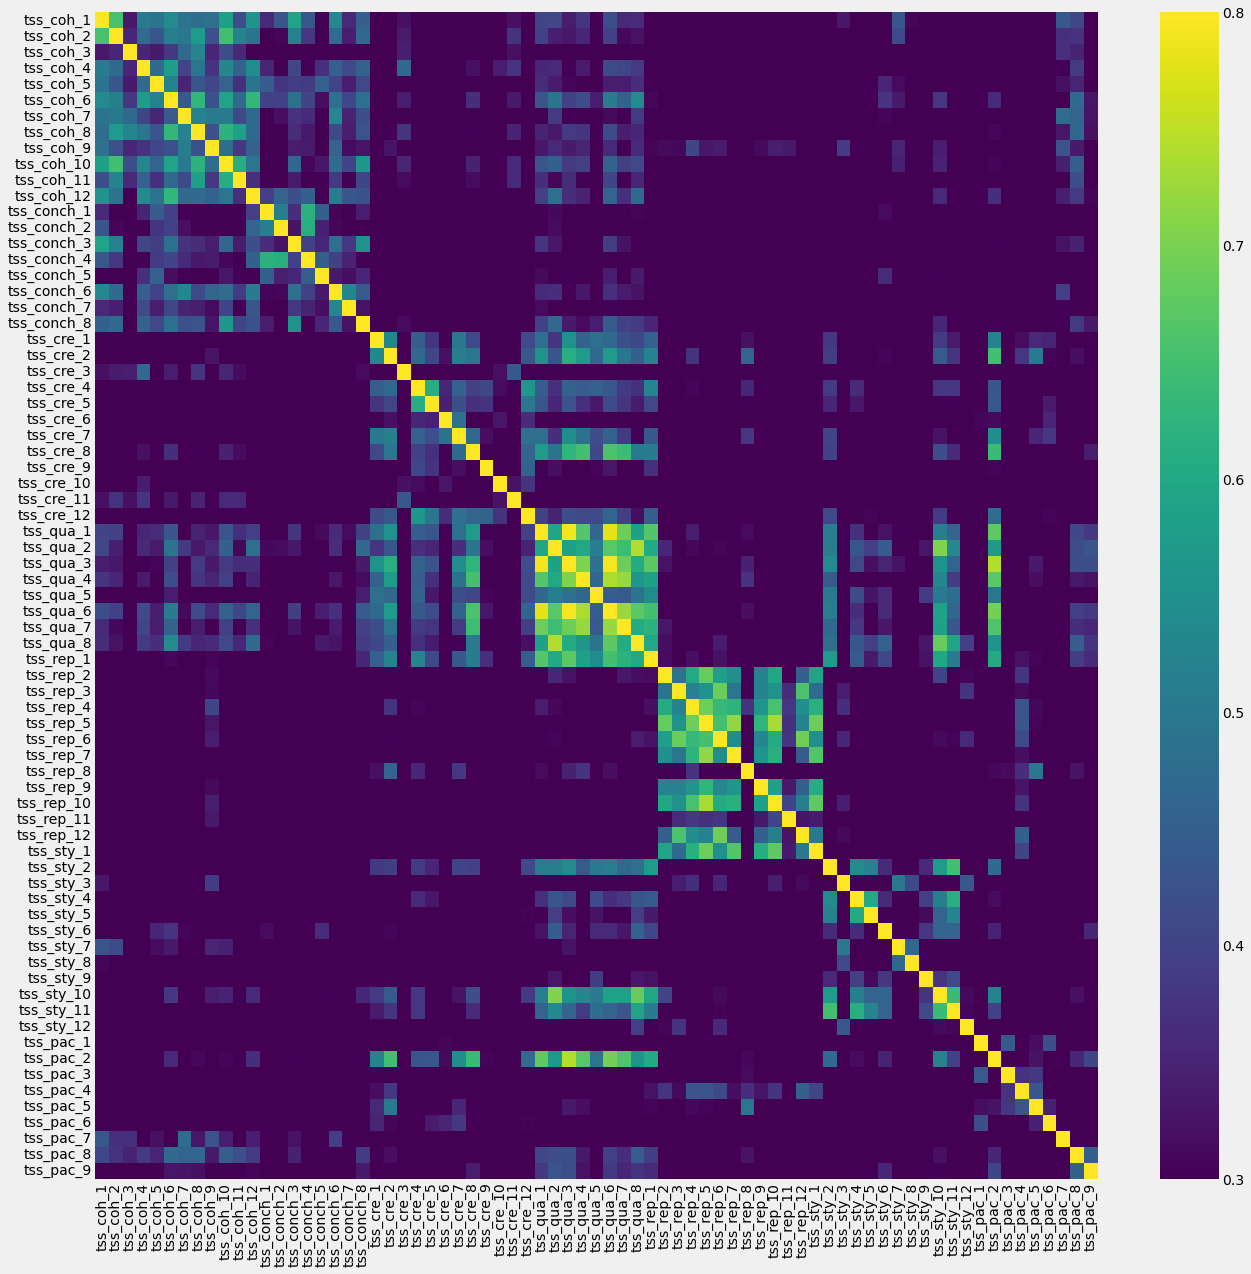

In [6]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [ ]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_6", "tss_cre_10", "tss_cre_11",
    "tss_rep_8", "tss_rep_10",
    "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

In [7]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [8]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [9]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 3.2406212435333033e-23

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 38.63
('The story was fun to read.')

Excluded item tss_coh_12. VIF: 31.37
('The story lacked logic.')

Excluded item tss_qua_6. VIF: 29.91
('I liked this story.')

Excluded item tss_coh_1. VIF: 27.12
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_qua_1. VIF: 25.23
('This story was enjoyable.')

Excluded item tss_cre_4. VIF: 24.40
('The story was creative.')

Excluded item tss_rep_5. VIF: 24.24
('In the story, the same things happened again and again.')

Excluded item tss_qua_8. VIF: 23.63
('The story was well-written.')

Excluded item tss_cre_2. VIF: 23.53
('The story was boring.')

Excluded item tss_rep_4. VIF: 23.18
('The story was very repetitive.')

Excluded item tss_conch_5. VIF: 22.54
('The descriptions of characters in the

In [10]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8550444873325297
All item KMOs are >.6


## Running the EFA

In [11]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

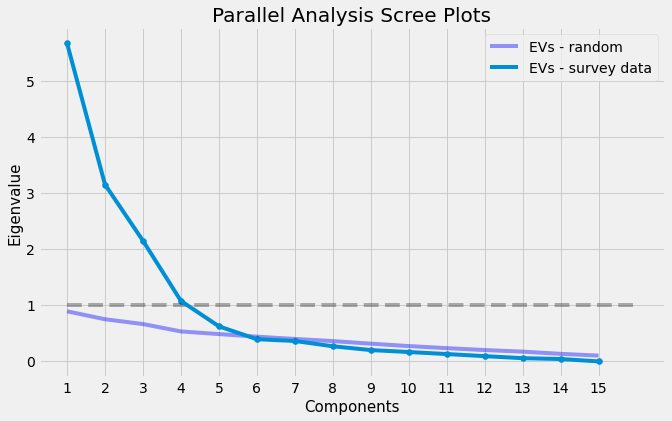

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.88				5.67
2	0.74				3.14
3	0.65				2.14
4	0.52				1.06
5	0.47				0.61
6	0.43				0.38
7	0.39				0.35
8	0.35				0.25
9	0.30				0.19
10	0.26				0.15
11	0.22				0.12
12	0.19				0.08
13	0.16				0.04
14	0.12				0.03
15	0.09				-0.02


In [12]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

### 5 factor solution

In [13]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=5, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.         -0.05552546 -0.24092325  0.19340462 -0.4267813 ]
 [-0.05552546  1.         -0.14522044  0.2467562  -0.03393383]
 [-0.24092325 -0.14522044  1.         -0.0564415   0.28020187]
 [ 0.19340462  0.2467562  -0.0564415   1.         -0.20844336]
 [-0.4267813  -0.03393383  0.28020187 -0.20844336  1.        ]]


In [14]:
def stepwise_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                 comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                 print_details=False, print_par_plot=False, print_par_table=False,
                 par_k=100, par_n_facs=15, iterative=True):

    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    curr_vars = copy.deepcopy(vars_analsis)

    efa.fit(data[curr_vars])

    if print_par_plot or print_par_table:
        parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                          print_graph=print_par_plot, print_table=print_par_table)

    # Check 1: Check communcalities
    print("Checking for low communalities")
    comms = pd.DataFrame(efa.get_communalities(),
                         index=tss_df[curr_vars].columns, columns=['Communality'])
    mask_low_comms = comms["Communality"] < comm_thresh

    if comms[mask_low_comms].empty:
        print("All communalities above {}\n".format(comm_thresh))
    else:
        # save bad items and remove them
        bad_items = comms[mask_low_comms].index
        print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
            len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                    item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)

    # Check 2: Check for low main loading
    print("Checking for low main loading")
    loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
    max_loadings = abs(loadings).max(axis=1)
    mask_low_main = max_loadings < main_thresh
    if max_loadings[mask_low_main].empty:
        print("All main loadings above {}\n".format(main_thresh))
    else:
        # save bad items and remove them
        bad_items = max_loadings[mask_low_main].index
        print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
            len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                    item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)

    # check 3: Check for high cross loadings
    print("Checking high cross loadings")

    # create df that stores main_load, largest crossload and difference between the two
    crossloads_df = pd.DataFrame(index=curr_vars)

    crossloads_df["main_load"] = abs(loadings).max(axis=1)
    crossloads_df["cross_load"] = abs(loadings).apply(
        lambda row: row.nlargest(2).values[-1], axis=1)
    crossloads_df["diff"] = crossloads_df["main_load"] - \
        crossloads_df["cross_load"]

    mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
        crossloads_df["diff"] < load_diff_thresh)

    if crossloads_df[mask_high_cross].empty:
        print("All cross_loadins loadings below {}".format(cross_thres),
              "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
    else:
        # save bad items and remove them
        bad_items = crossloads_df[mask_high_cross].index
        print("Detected {} items with high cross loading. Excluding them for next analysis.\n"
              .format(len(bad_items)))
        for item in bad_items:
            if print_details:
                print("Removed item {}: {}\nLoadings: \n{}\n".format(
                    item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)

    corrs = data[curr_vars].corr()
    det = np.linalg.det(corrs)
    print("\nDeterminant of correlation matrix: {}".format(det))
    if det > 0.00001:
        print("Determinant looks good!")
    else:
        print("Determinant is smaller than 0.00001!")
        print("Consider using stricer criteria and/or removing highly correlated vars")

    kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
    print("Overall KMO: {}".format(kmo[1]))

    i = 0
    low_item_kmo = False
    for item_kmo in kmo[0]:
        if item_kmo < .6:
            low_item_kmo = True
            item_label = curr_vars[i]
            print("Low KMO for {} ('{}'): {}"
                  .format(item_label, items_descr[item_label], item_kmo))
        i += 1
    if low_item_kmo == False:
        print("All item KMOs are >.6")

    return(efa, curr_vars)


def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15, iterative=True):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")


def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Communality: 0.1930

Fitted solution #2



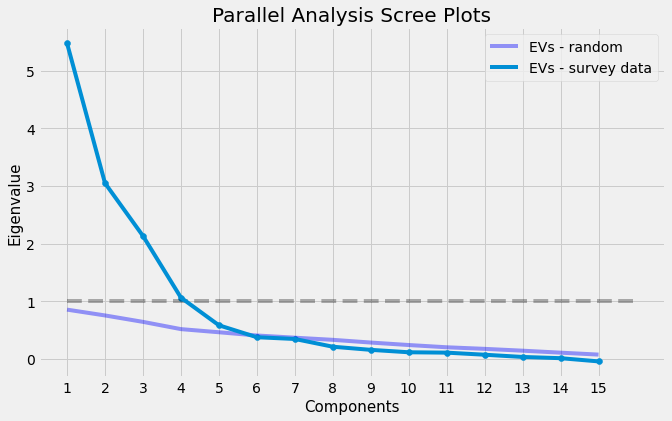

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 4 items with low main loading. Excluding them for next analysis.

Removed item tss_cre_6: It was surprising how things turned out in the story.
Main (absolute) Loading: 0.3767

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3886

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3931

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3733

Fitted solution #3



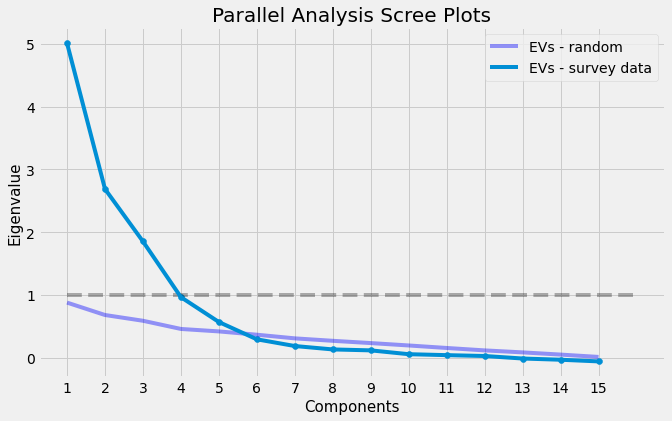

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 3 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0    0.044228
1   -0.485546
2    0.338761
3    0.099553
4    0.138069
Name: tss_coh_9, dtype: float64

Removed item tss_conch_8: It was easy to understand the motivation of the characters in the story.
Loadings: 
0    0.304069
1    0.451063
2   -0.021386
3    0.042772
4   -0.070126
Name: tss_conch_8, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0    0.525735
1   -0.001432
2    0.075220
3   -0.373597
4    0.027731
Name: tss_cre_7, dtype: float64

Fitted solution #4



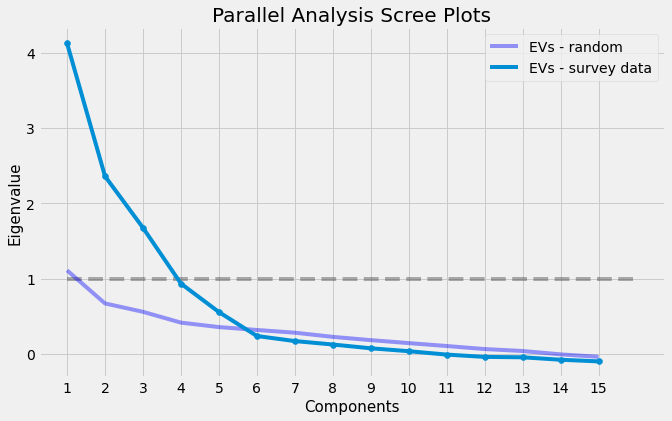

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_6: The story felt like a coherent story.
Loadings: 
0    0.279995
1    0.475672
2   -0.046971
3    0.103720
4   -0.247599
Name: tss_coh_6, dtype: float64

Fitted solution #5



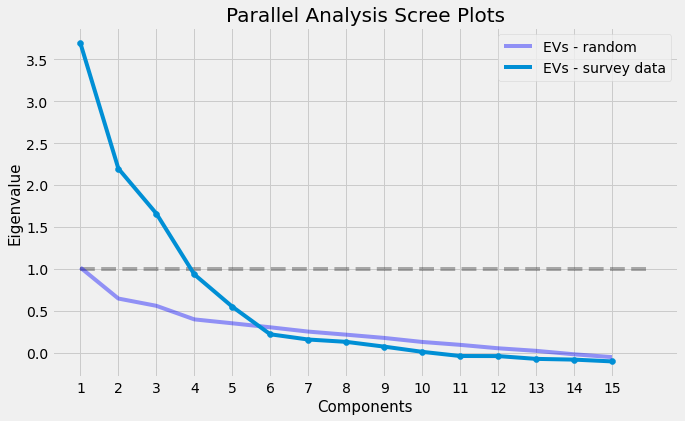

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0016656715246120856
Determinant looks good!
Overall KMO: 0.7939503376574565
All item KMOs are >.6


In [15]:
five_facs = iterative_efa(tss_df, items_analysis_li, n_facs=5, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True)

In [16]:
efa_5 = five_facs[0]
items_5 = five_facs[1]

print_sorted_loadings(efa_5, items_5, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                   0                                             descr
tss_qua_2   0.668098                    This story is of high quality.
tss_qua_7   0.617821  I would like to read more stories like this one.
tss_cre_12  0.615123                         The story was innovative.
tss_sty_5   0.527609                The story used complex vocabulary.
tss_cre_9   0.521429            The setting of the story was original.
tss_sty_9   0.483027       The story contained a great deal of detail. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_10  0.767681                            Characters said or did the same thing many times over.
tss_rep_9   0.732548  One character did something he or she had already done previously in this story.
tss_rep_3   0.701150            Many sentences in the story had frequently repeated words and phrases.
tss_rep_11  0.452764       

In [17]:
items_per_fac_5 = rev_items_and_return(tss_df, efa_5, items_5)

for factor_n in items_per_fac_5:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.7506, 95% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.7290
tss_cre_12: 0.7074
tss_qua_2: 0.6798
tss_qua_7: 0.6966
tss_sty_5: 0.7309
tss_sty_9: 0.7404


Internal consistency for factor 1:
Cronbachs alpha = 0.7728, 95% CI = [0.73, 0.81]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7023
tss_rep_9: 0.7014
tss_rep_10: 0.6721
tss_rep_11: 0.7864


Internal consistency for factor 2:
Cronbachs alpha = 0.7260, 95% CI = [0.67, 0.77]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6903
tss_pac_3: 0.6795
tss_pac_5: 0.6545
tss_pac_1_rev: 0.6797
tss_pac_6_rev: 0.6914


Internal consistency for factor 3:
Cronbachs alpha = 0.6919, 95% CI = [0.63, 0.74]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.6091
tss_coh_11: 0.6197
tss_cre_3: 0.6666
tss_pac_8: 0.6487
tss_pac_7_rev: 0.6619


Internal consistency for factor 4:


In [18]:
items_5_2 = copy.deepcopy(items_5)

items_5_2.remove("tss_rep_11")

# items_5_2.extend(["tss_rep_4", "tss_rep_5",
#                   "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
# items_5_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
#                  "tss_cre_5", "tss_cre_8", "tss_cre_10", "tss_cre_11"])
# items_5_2.extend(["tss_pac_2", "tss_pac_4"])
#items_5_2.extend(["tss_sty_1", "tss_sty_2", "tss_sty_4", "tss_sty_11"])
items_5_2.extend(["tss_coh_1", "tss_coh_2", "tss_coh_4", "tss_coh_5",
                  "tss_coh_7", "tss_coh_8", "tss_coh_10", "tss_coh_12",
                  "tss_conch_1", "tss_conch_3", 
                  "tss_conch_5", "tss_conch_6"])

In [19]:
items_5_2 = reduce_multicoll(
    tss_df, items_5_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 2.997061592933587e-07

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_coh_12. VIF: 23.54
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 20.87
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_coh_7. VIF: 18.18
('The story felt like it contained a bunch of jumbled topics.')

Excluded item tss_conch_5. VIF: 18.14
('The descriptions of characters in the story were plausible.')

Excluded item tss_coh_10. VIF: 16.67
('The story had a clearly identifiable plot.')

Done! Determinant is now: 0.000024
I have excluded 5 redunant items with 28 items remaining


Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_coh_5: This story’s events occurred in a plausible order
Main (absolute) Loading: 0.3730

Removed item tss_conch_3: My understanding of the characters in the story is unclear.
Main (absolute) Loading: 0.3861

Fitted solution #2



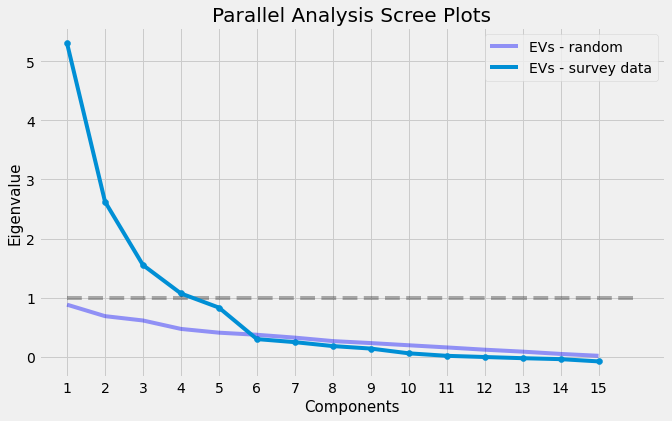

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 7.386822991517943e-05
Determinant looks good!
Overall KMO: 0.8437478911325788
All item KMOs are >.6


In [20]:
five_facs_2 = iterative_efa(tss_df, items_5_2, n_facs=5, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True)

In [21]:
efa_5_2 = five_facs_2[0]
items_5_2 = five_facs_2[1]

print_sorted_loadings(efa_5_2, items_5_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                              descr
tss_coh_8    0.773872                  The story stayed on topic with a consistent plot.
tss_coh_11   0.675105                                       The story had a clear theme.
tss_coh_2   -0.673510             I had a hard time recognizing the thread of the story.
tss_coh_3    0.591243                            The story appeared to be a single plot.
tss_coh_4    0.588596                               The plot of the story was plausible.
tss_cre_3    0.546296                 The plot development in the story was predictable.
tss_pac_8    0.516974               All elements of the story were relevant to the plot.
tss_conch_6 -0.441106  The behavior of characters in the story seemed completely random.
tss_pac_7   -0.425344           Many things seemed to be happening at once in the story. 

Relevant loadings for factor 1
                   1                          

In [23]:
items_per_fac_5_2 = rev_items_and_return(tss_df, efa_5_2, items_5_2)

for factor_n in items_per_fac_5_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8488, 95% CI = [0.82, 0.87]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8362
tss_coh_11: 0.8277
tss_cre_3: 0.8429
tss_pac_8: 0.8402
tss_coh_4: 0.8270
tss_coh_8: 0.8175
tss_pac_7_rev: 0.8443
tss_coh_2_rev: 0.8239
tss_conch_6_rev: 0.8352


Internal consistency for factor 1:
Cronbachs alpha = 0.7506, 95% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.7290
tss_cre_12: 0.7074
tss_qua_2: 0.6798
tss_qua_7: 0.6966
tss_sty_5: 0.7309
tss_sty_9: 0.7404


Internal consistency for factor 2:
Cronbachs alpha = 0.7260, 95% CI = [0.67, 0.77]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6903
tss_pac_3: 0.6795
tss_pac_5: 0.6545
tss_pac_1_rev: 0.6797
tss_pac_6_rev: 0.6914


Internal consistency for factor 3:
Cronbachs alpha = 0.8061, 95% CI = [0.77, 0.84]

Cronbach's alpha when excluding variable...
tss_conch_2: 0.7621
tss_conch_4: 0.6731
tss_conch_1_rev: 0.7620


Internal consistency for factor 

In [24]:
# items_per_fac_4_2[1].remove("tss_rep_11")
# items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_5_2

{0: ['tss_coh_3',
  'tss_coh_11',
  'tss_cre_3',
  'tss_pac_8',
  'tss_coh_4',
  'tss_coh_8',
  'tss_pac_7_rev',
  'tss_coh_2_rev',
  'tss_conch_6_rev'],
 1: ['tss_cre_9',
  'tss_cre_12',
  'tss_qua_2',
  'tss_qua_7',
  'tss_sty_5',
  'tss_sty_9'],
 2: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev', 'tss_pac_6_rev'],
 3: ['tss_conch_2', 'tss_conch_4', 'tss_conch_1_rev'],
 4: ['tss_rep_3', 'tss_rep_9', 'tss_rep_10']}

# Examine Scale Scores

In [25]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_5_2[0]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[0])/3)
mask_suff_data_cre = tss_df[items_per_fac_5_2[1]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[1])/3)
mask_suff_data_pac = tss_df[items_per_fac_5_2[2]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[2])/3)
mask_suff_data_conch = tss_df[items_per_fac_5_2[3]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[3])/3)
mask_suff_data_rep = tss_df[items_per_fac_5_2[4]].isna().sum(
    axis=1) <= round(len(items_per_fac_5_2[4])/3)

tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_5_2[0]].mean(
    axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[1]].mean(
    axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_5_2[2]].mean(
    axis=1)
tss_df["tss_conch"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[3]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_5_2[4]].mean(
    axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_conch"] = (tss_df["tss_conch"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [ ]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

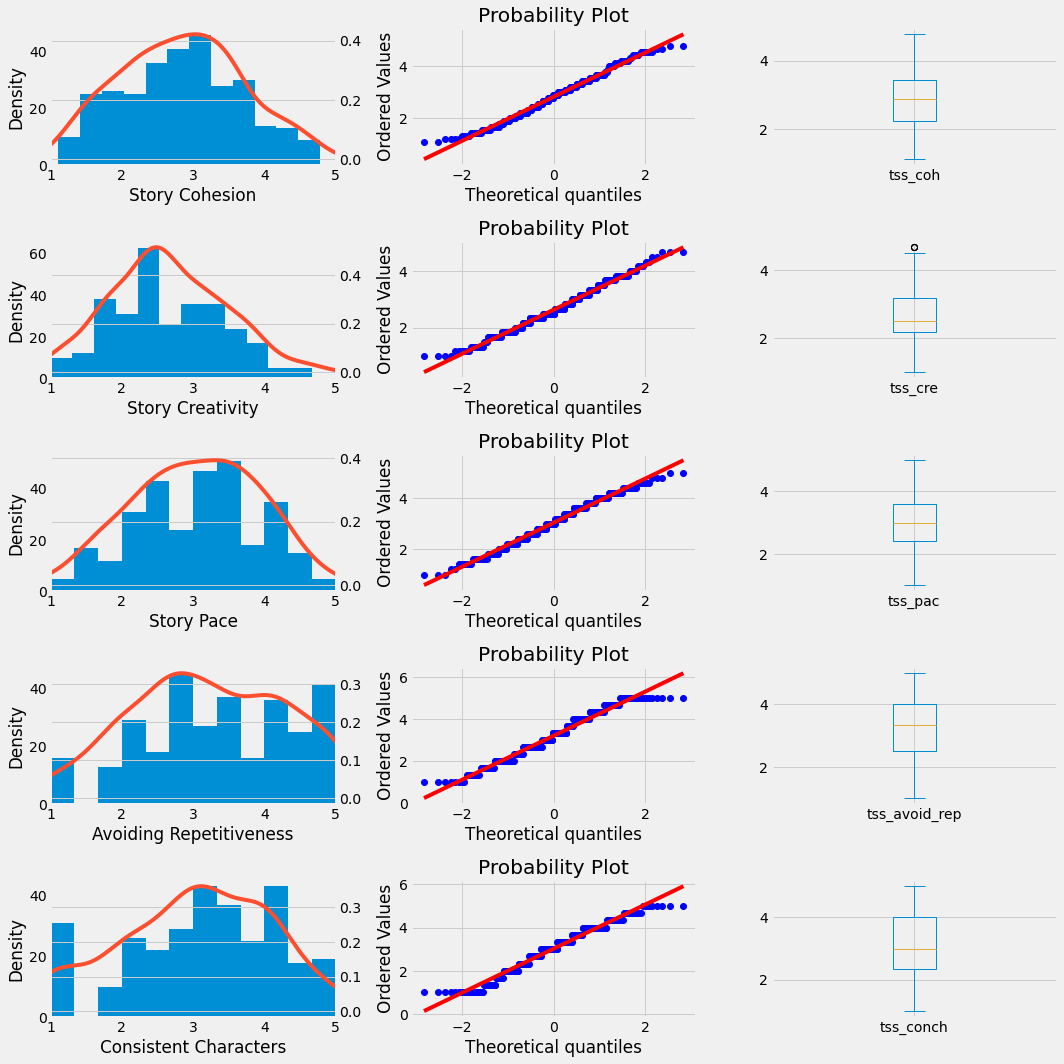

In [26]:
# Check scale distributions
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")
ax4.set_xlim(1, 5)

ax5 = tss_df["tss_conch"].plot.hist(ax=axes[4, 0], bins=12)
tss_df["tss_conch"].plot.kde(ax=axes[4, 0], secondary_y=True)
ax5.set_xlabel("Consistent Characters")
ax5.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])
stats.probplot(tss_df["tss_conch"], dist="norm", plot=axes[4, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])
tss_df["tss_conch"].plot.box(ax=axes[4, 2])

fig.tight_layout()
plt.show()

In [27]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac,tss_conch
tss_coh,1.000000,0.302867,0.151803,-0.049296,0.450458
tss_cre,0.302867,1.000000,0.197586,0.238722,0.272954
tss_avoid_rep,0.151803,0.197586,1.000000,0.175758,0.193136
tss_pac,-0.049296,0.238722,0.175758,1.000000,0.043631
tss_conch,0.450458,0.272954,0.193136,0.043631,1.000000


# Analyze Impact of Preset & Prompt

<Figure size 720x720 with 0 Axes>

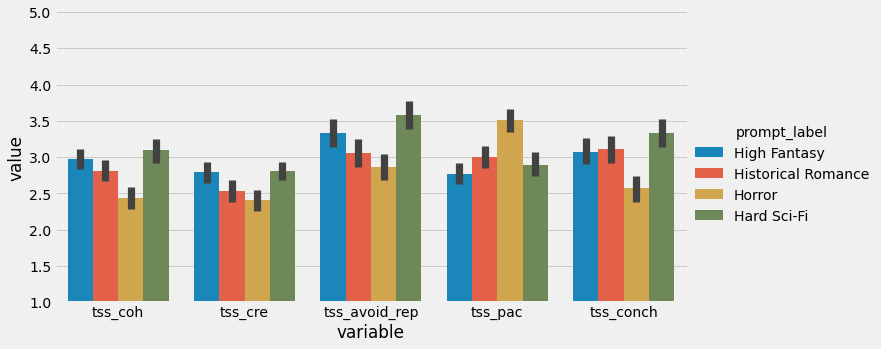

In [28]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

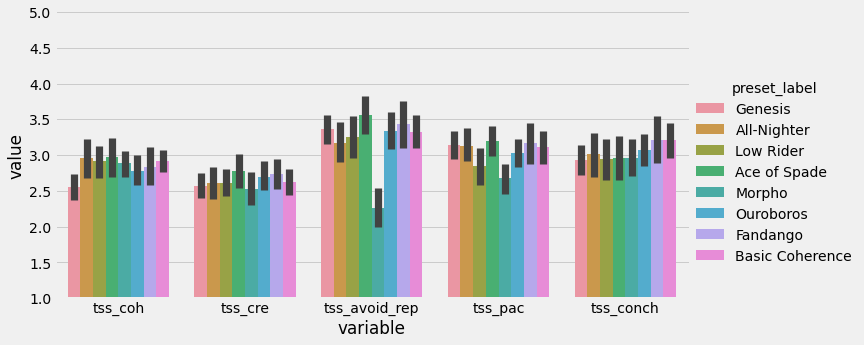

In [29]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

## Use Word Count as a Control Variable?

<AxesSubplot:xlabel='word_count', ylabel='tss_conch'>

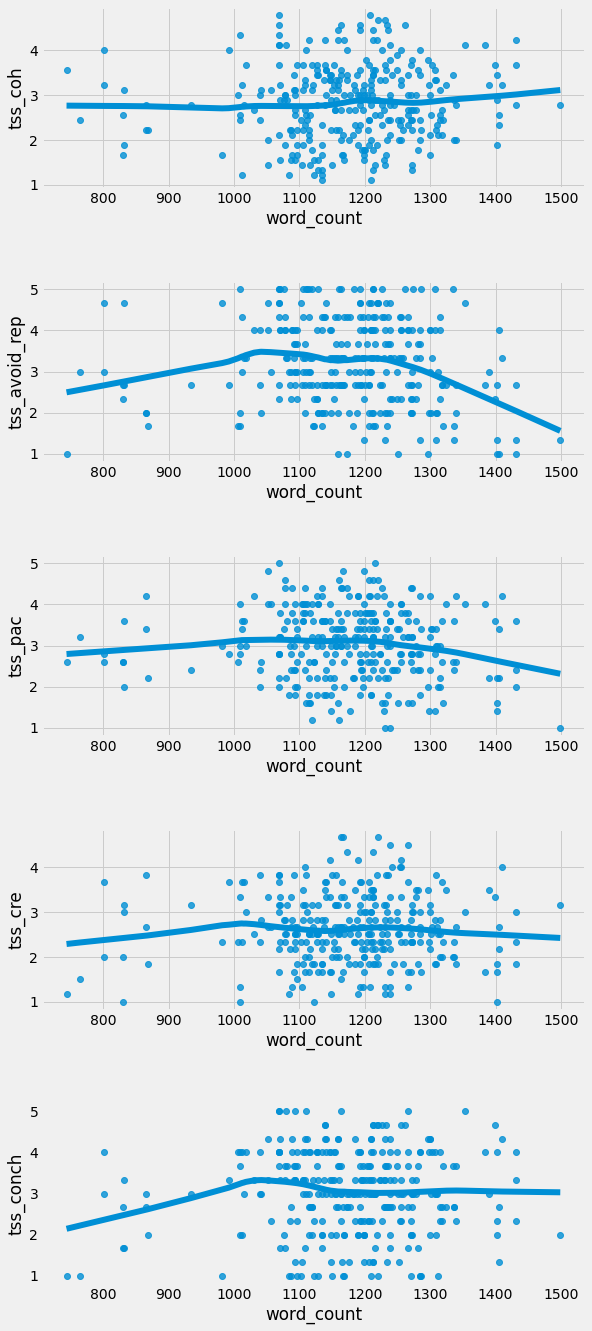

In [30]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=tss_df, y="tss_conch",
            x="word_count", lowess=True, ax=axes[4])

In [31]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0347    RMSE: 0.8409
Model performance for quadratic model predicting tss_coh:
r-square: -0.0372    RMSE: 0.8418
Model performance for cubic model predicting tss_coh:
r-square: -0.0409    RMSE: 0.8434

Model performance for linear model predicting tss_cre:
r-square: -0.0294    RMSE: 0.7742
Model performance for quadratic model predicting tss_cre:
r-square: -0.0349    RMSE: 0.7751
Model performance for cubic model predicting tss_cre:
r-square: -0.0468    RMSE: 0.7793

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0403    RMSE: 1.0517
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0071    RMSE: 1.0252
Model performance for cubic model predicting tss_avoid_rep:
r-square: -0.0013    RMSE: 1.0296

Model performance for linear model predicting tss_pac:
r-square: -0.0552    RMSE: 0.8656
Model performance for quadratic model predicting tss_pac:
r-square: -0.0373    RMSE:

## ANOVA Model Diagnostics

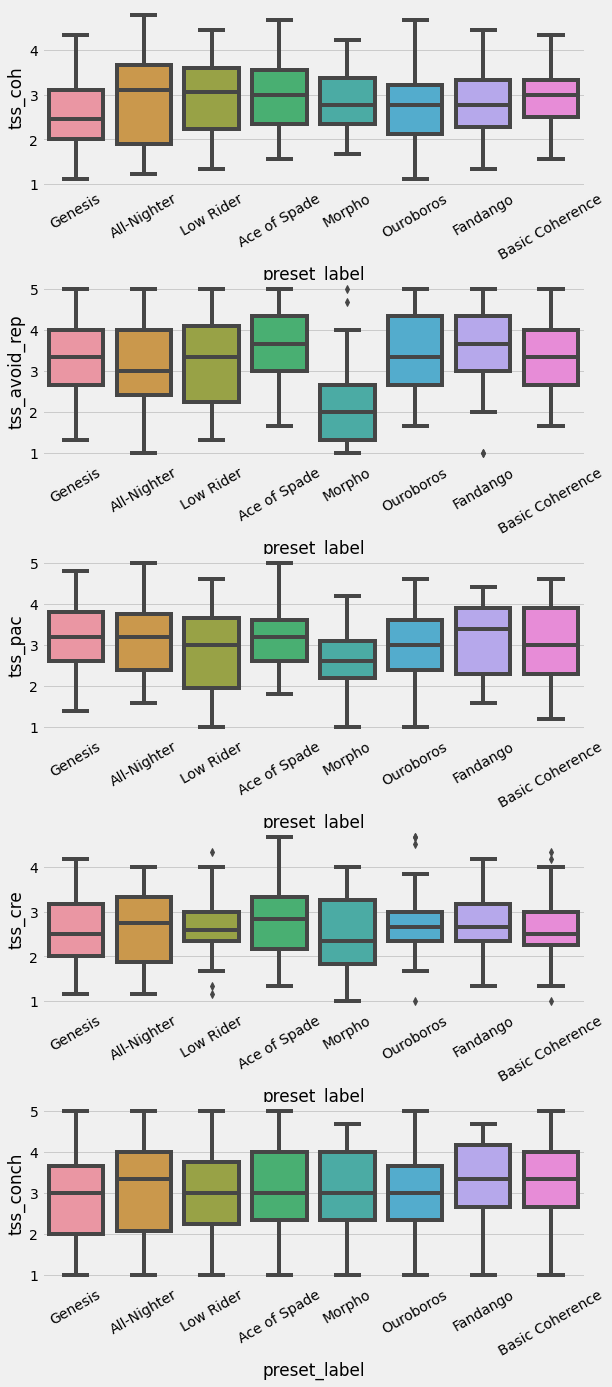

In [32]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="preset_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

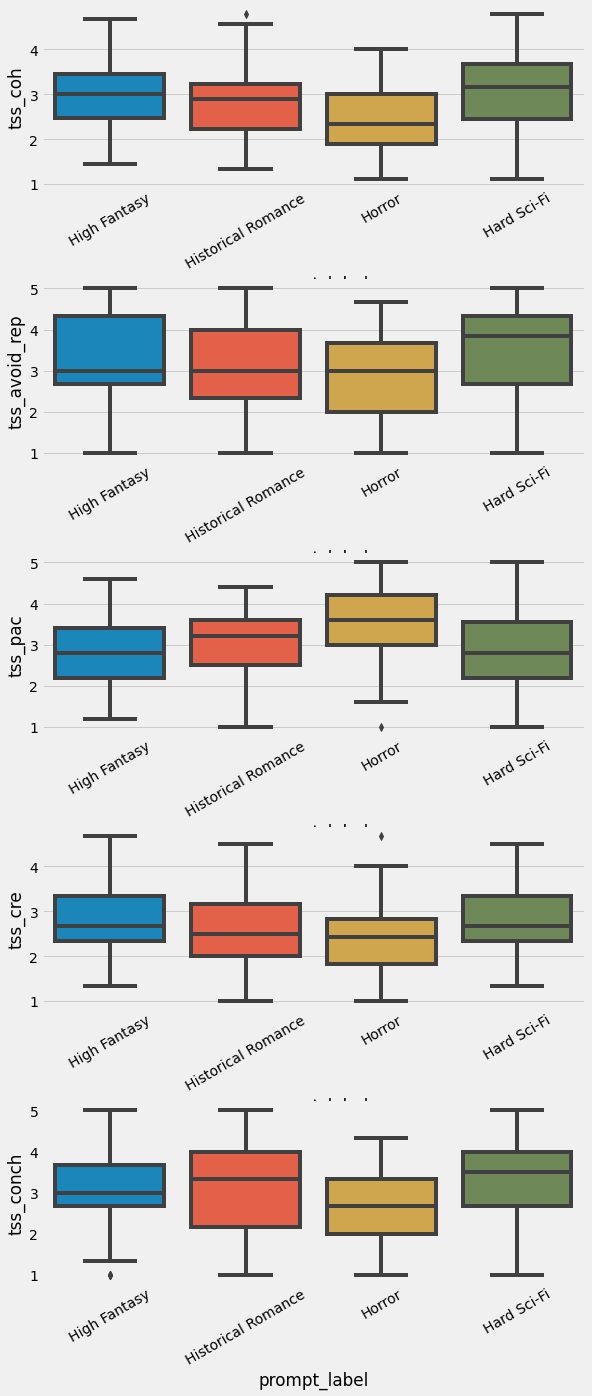

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="prompt_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [34]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [35]:
# Outliers for Presets

# Outliers Coherence
# print("Exterme outliers on tss_coh, Basic Coherence preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_coh")

# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
print("\nExterme outliers on tss_rep, Fandango preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Fandango"], "tss_avoid_rep")

# # Outliers pace
# print("\nExterme outliers on tss_pac, Morpho preset")
# determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_pac")

# Outliers creativity
print("\nExterme outliers on tss_cre, Low Rider preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Low Rider"], "tss_cre")
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_cre")
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_cre")

# Outliers for Prompts

# # Coherence
# print("\nExterme outliers on tss_coh, Hard Sci-Fi prompt")
# determine_outliers(tss_df[tss_df["prompt_label"] == "Hard Sci-Fi"], "tss_coh")

# Pace
print("\nExterme outliers on tss_pac, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")

# Creativity
print("\nExterme outliers on tss_cre, Romance prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Historical Romance"], "tss_cre")


Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.33
75th Percentile (Q3): 2.67
IQR: 1.33
Will count cases as outlier with values less than -2.67 or more than 6.67.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Fandango preset
25th Percentile (Q1): 3.00
75th Percentile (Q3): 4.33
IQR: 1.33
Will count cases as outlier with values less than -1.00 or more than 8.33.
With these criteria there are no outlier in the data

Exterme outliers on tss_cre, Low Rider preset
25th Percentile (Q1): 2.33
75th Percentile (Q3): 3.00
IQR: 0.67
Will count cases as outlier with values less than 0.33 or more than 5.00.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouroboros preset
25th Percentile (Q1): 2.33
75th Percentile (Q3): 3.00
IQR: 0.67
Will count cases as outlier with values less than 0.33 or more than 5.00.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouroboros preset
25t

In [36]:
#tss_no_out = tss_df[~(tss_df.index == 7)].copy()
tss_no_out = tss_df

In [37]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(groups_li), len(vars_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(vars_li)-1):
            x += 1
        else:
            x = 0
            y += 1

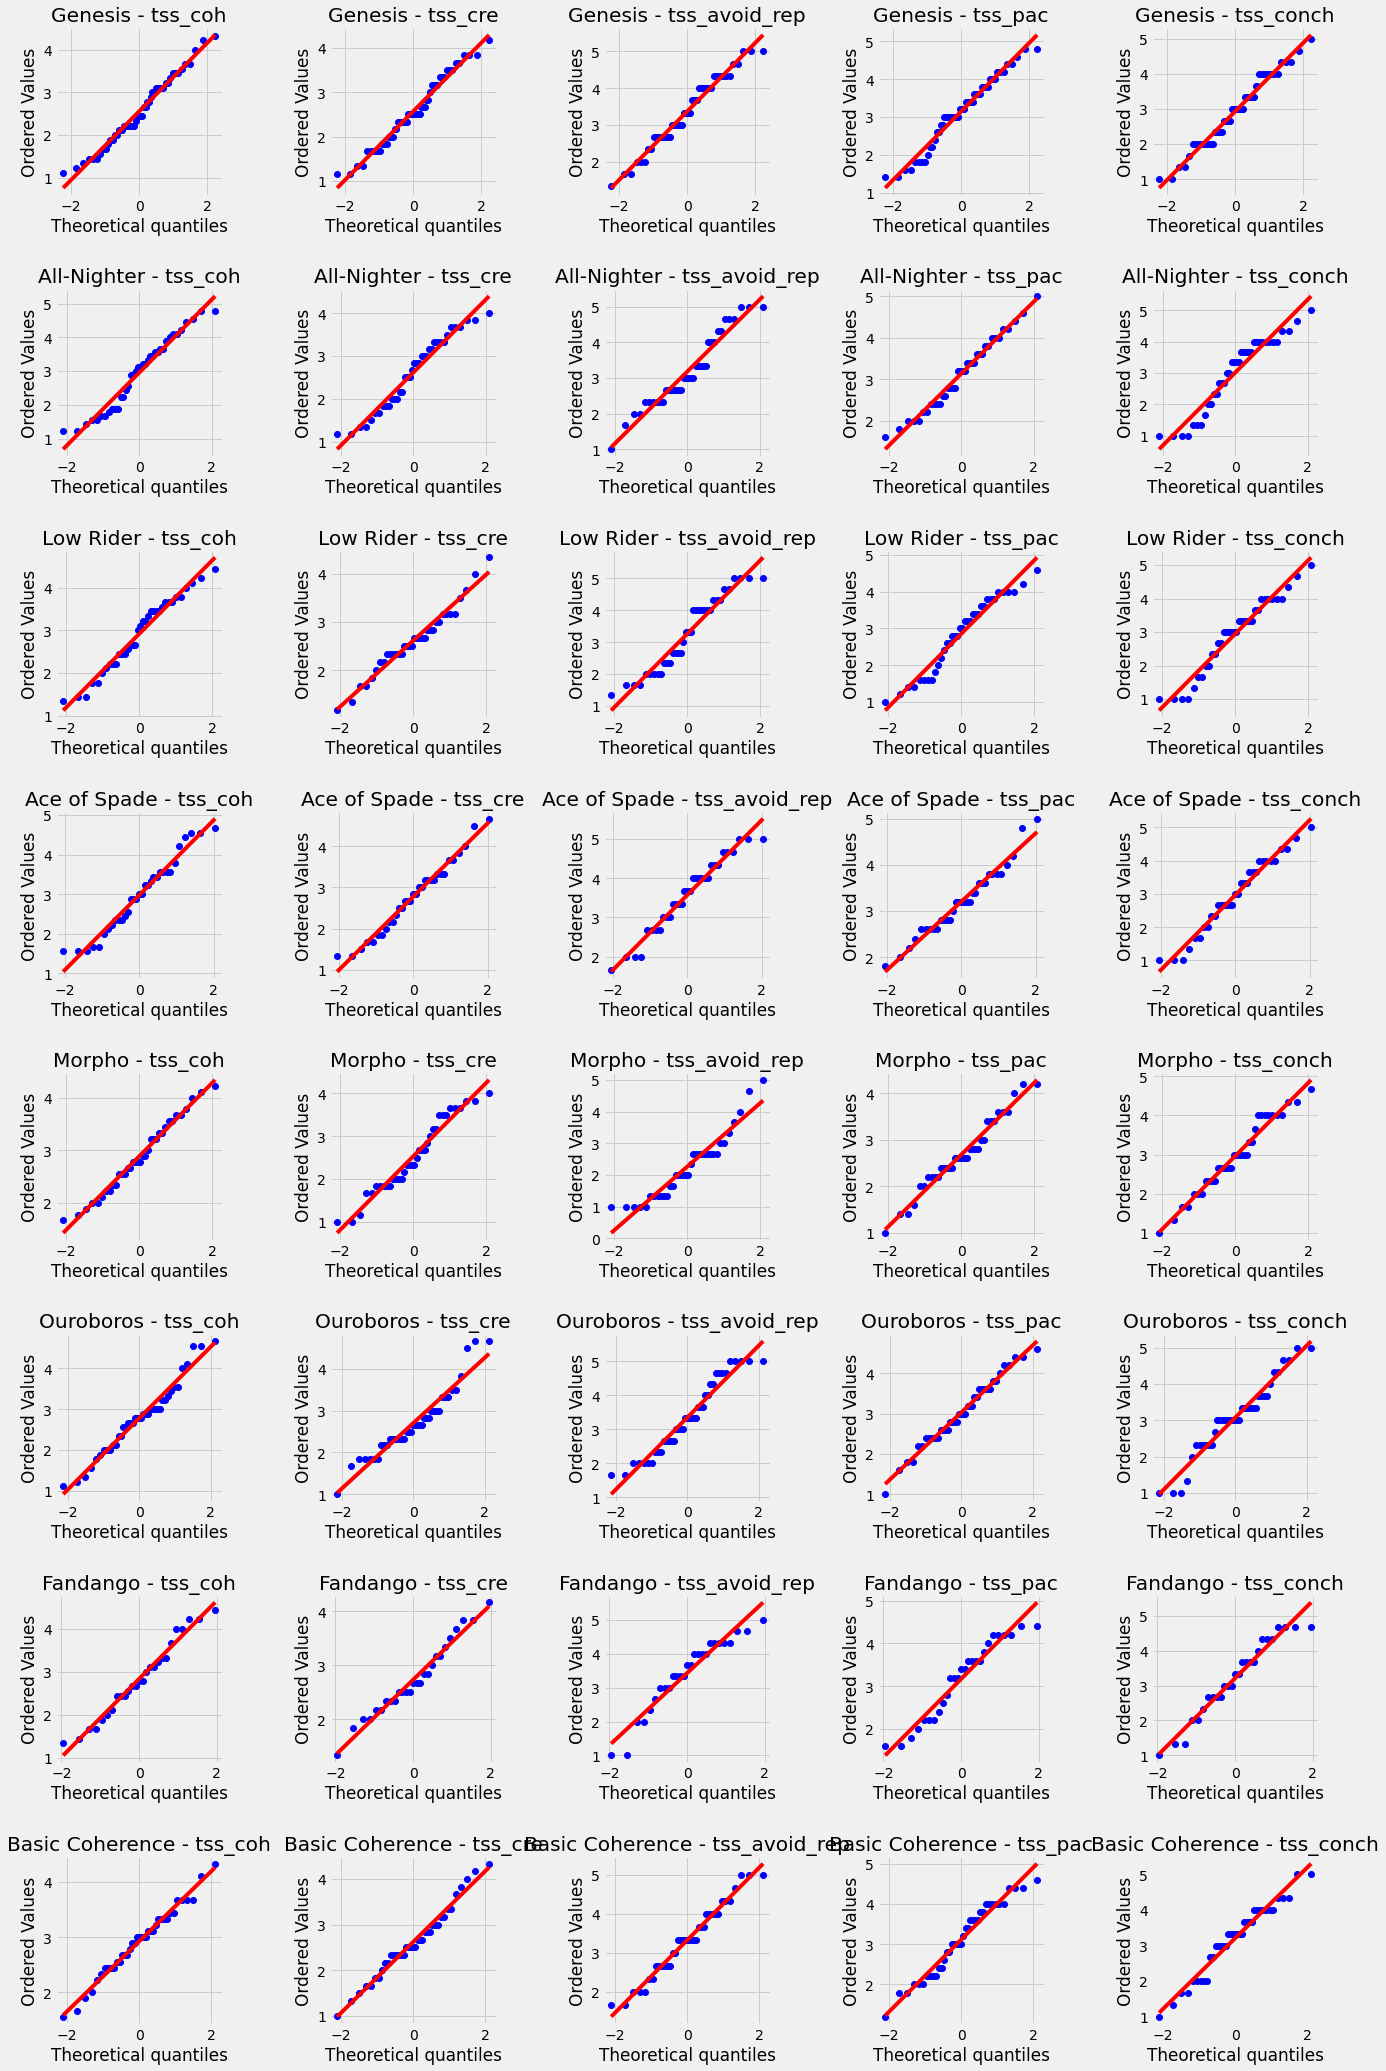

In [38]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(20, 30))

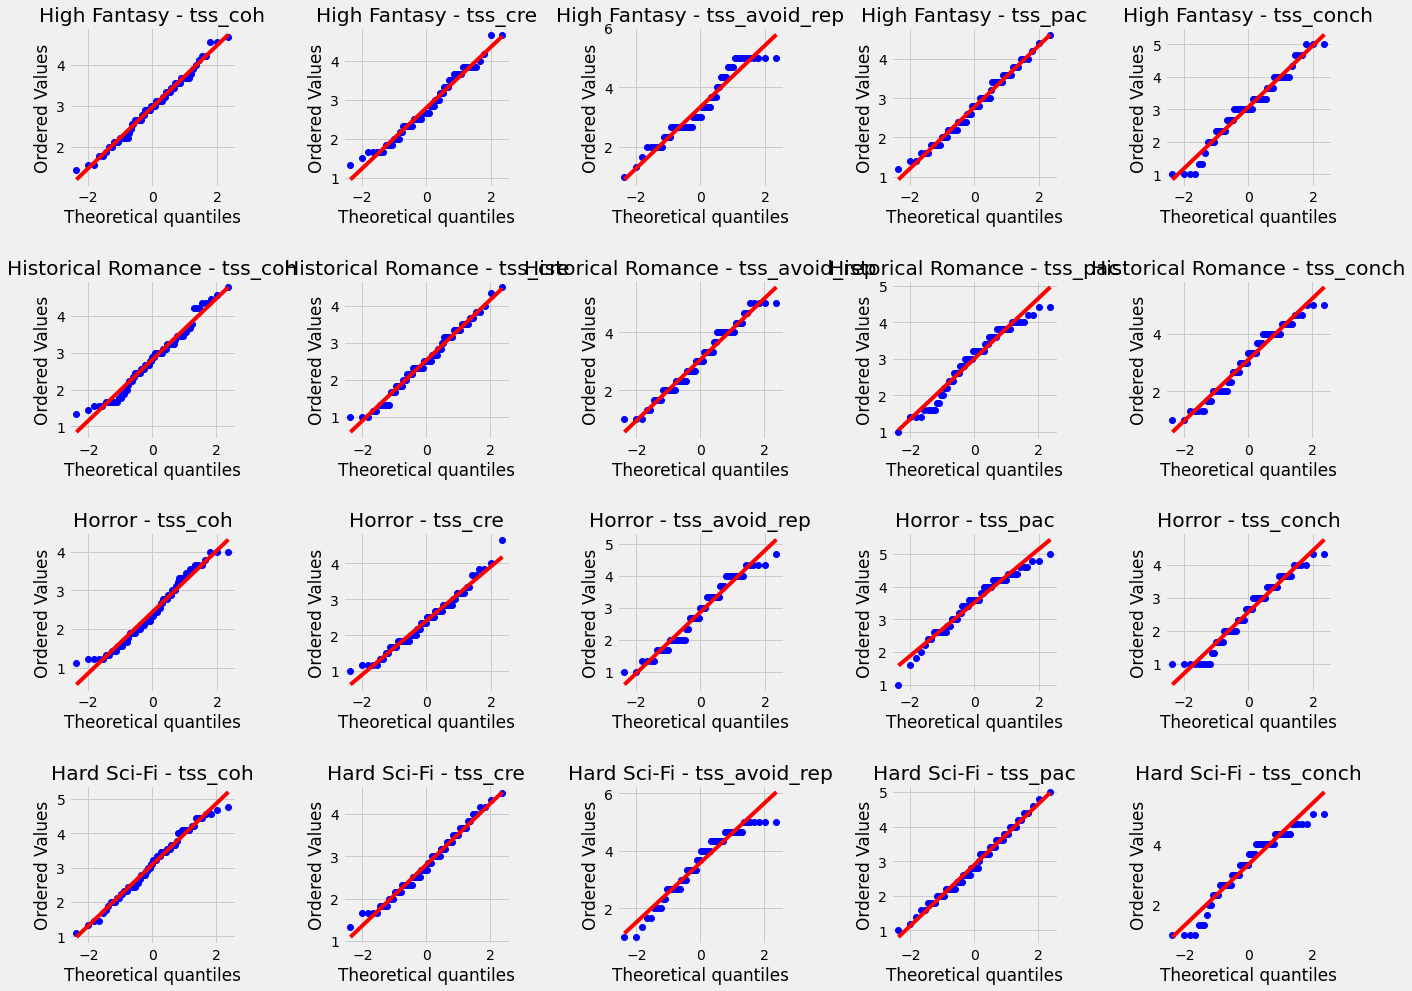

In [39]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 15))

In [40]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {:.2f}, coefficient of sample size variation is {:.2f}, variance ratio is {:.2f}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [41]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.39
Largest variance for All-Nighter: 1.14
Variance ratio for: 2.94
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.21. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.21, so smaller than 0 and larger than or equal to -.5, ,coefficient of sample size variation is 0.33, larger than .16, and variance ratio is 2.94, larger than 2. F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).

Prompt
Smallest variance for High Fantasy: 0.54
Largest variance for Hard Sci-Fi: 0.77
Variance ratio for: 1.42
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Low Rider: 0.45
Largest variance for Ace of Spade: 0.75
Variance ratio for: 1.66
Variance ratio is larger 1.5. Now doing additional checks to see if F-test

## Running the ANOVA

In [42]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)       6.391441    7.0  1.393131  0.207810
C(prompt_label, Sum)      17.536888    3.0  8.919130  0.000011
C(sample, Treatment(0))    0.365308    1.0  0.557379  0.455921
Residual                 190.722439  291.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.645
Date:                Mon, 11 Apr 2022   Prob (F-statistic):           7.42e-05
Time:                        14:11:56   Log-Likelihood:                -359.81
No. Observations:                 303   AIC:                             743.6
Df Residuals:                     291   BIC:                             788.2
Df Model:                          11        

C(preset_label, Sum(0))[S.Ouroboros]:	coef: 0.040	p: 0.783 
C(prompt_label, Sum(0))[S.Horror]:	coef: -0.453	p: 0.000




In [43]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [44]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Intercept,2.879407,0.000000,NaN,0.118454,2.508762,0.000000,NaN,0.098181,3.417794,0.000000e+00,NaN,0.141219,3.116637,0.000000e+00,NaN,0.112246,2.964774,2.238945e-224,NaN,0.152501
Genesis,-0.279124,0.007318,0.058543,0.171184,-0.067182,0.505554,0.941757,0.165979,0.171684,1.648697e-01,4.396525e-01,0.203326,0.096126,3.771191e-01,5.028255e-01,0.179020,-0.070067,5.946069e-01,0.783071,0.216564
All-Nighter,0.058542,0.704483,0.776168,0.253889,-0.047696,0.680387,0.941757,0.190451,-0.109780,4.544063e-01,5.193215e-01,0.241377,0.120625,3.722763e-01,5.028255e-01,0.222380,-0.066766,6.988050e-01,0.783071,0.283820
Low Rider,0.080220,0.551173,0.776168,0.221392,-0.018527,0.866630,0.941757,0.181457,0.046192,7.696330e-01,7.696330e-01,0.259441,-0.214312,1.715167e-01,4.573778e-01,0.257807,-0.062418,7.003254e-01,0.783071,0.266754
Ace of Spade,0.142091,0.302205,0.776168,0.226534,0.148310,0.282411,0.941757,0.226946,0.387651,1.307933e-02,5.231733e-02,0.256942,0.144493,1.658333e-01,4.573778e-01,0.171514,-0.070694,6.838753e-01,0.783071,0.285575
Morpho,0.031086,0.776168,0.776168,0.179840,-0.116052,0.356426,0.941757,0.206993,-0.948140,4.348867e-10,3.479094e-09,0.249890,-0.351303,3.243045e-03,2.594436e-02,0.196297,-0.069687,6.238023e-01,0.783071,0.233704
Ouroboros,-0.081045,0.499902,0.776168,0.197596,0.037743,0.730505,0.941757,0.180234,0.116146,4.263039e-01,5.193215e-01,0.240146,-0.005351,9.662522e-01,9.662522e-01,0.208025,0.039981,7.830712e-01,0.783071,0.238863
Fandango,-0.052926,0.751222,0.776168,0.274597,0.054929,0.694591,0.941757,0.230114,0.186676,3.094540e-01,4.951263e-01,0.302109,0.163159,2.745370e-01,5.028255e-01,0.245611,0.104786,5.893567e-01,0.783071,0.319318
Basic Coherence,0.101155,0.319679,0.776168,0.167202,0.008475,0.941757,0.941757,0.190797,0.149571,2.813699e-01,4.951263e-01,0.228381,0.046561,6.996135e-01,7.995583e-01,0.198491,0.194863,1.932030e-01,0.783071,0.246335
High Fantasy,0.159954,0.043644,0.058192,0.130410,0.168549,0.031364,0.041819,0.128803,0.152897,1.206195e-01,1.243018e-01,0.162026,-0.259658,1.394821e-03,2.789642e-03,0.133647,0.059907,5.443181e-01,0.544318,0.162524


In [45]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis=1)

params_df[mask_sig]

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Genesis,-0.279124,0.007318,0.058543,0.171184,-0.067182,0.505554,0.941757,0.165979,0.171684,1.648697e-01,4.396525e-01,0.203326,0.096126,3.771191e-01,5.028255e-01,0.179020,-0.070067,0.594607,0.783071,0.216564
Ace of Spade,0.142091,0.302205,0.776168,0.226534,0.148310,0.282411,0.941757,0.226946,0.387651,1.307933e-02,5.231733e-02,0.256942,0.144493,1.658333e-01,4.573778e-01,0.171514,-0.070694,0.683875,0.783071,0.285575
Morpho,0.031086,0.776168,0.776168,0.179840,-0.116052,0.356426,0.941757,0.206993,-0.948140,4.348867e-10,3.479094e-09,0.249890,-0.351303,3.243045e-03,2.594436e-02,0.196297,-0.069687,0.623802,0.783071,0.233704
High Fantasy,0.159954,0.043644,0.058192,0.130410,0.168549,0.031364,0.041819,0.128803,0.152897,1.206195e-01,1.243018e-01,0.162026,-0.259658,1.394821e-03,2.789642e-03,0.133647,0.059907,0.544318,0.544318,0.162524
Horror,-0.382924,0.000002,0.000009,0.133376,-0.234901,0.002324,0.009295,0.126873,-0.356910,1.572257e-04,6.289027e-04,0.155334,0.472330,1.044198e-08,4.176794e-08,0.135744,-0.452701,0.000003,0.000012,0.159332
Hard Sci-Fi,0.251661,0.002662,0.005325,0.137787,0.174528,0.019866,0.039732,0.123267,0.352508,3.316904e-04,6.633808e-04,0.161547,-0.167530,6.573369e-02,8.764492e-02,0.149743,0.314310,0.002564,0.005127,0.171433


In [46]:
tss_no_out["preset_label"].value_counts()

Genesis            53
Ouroboros          41
Basic Coherence    39
All-Nighter        38
Low Rider          36
Morpho             36
Ace of Spade       33
Fandango           27
Name: preset_label, dtype: int64

In [ ]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

## Visualizing the Results

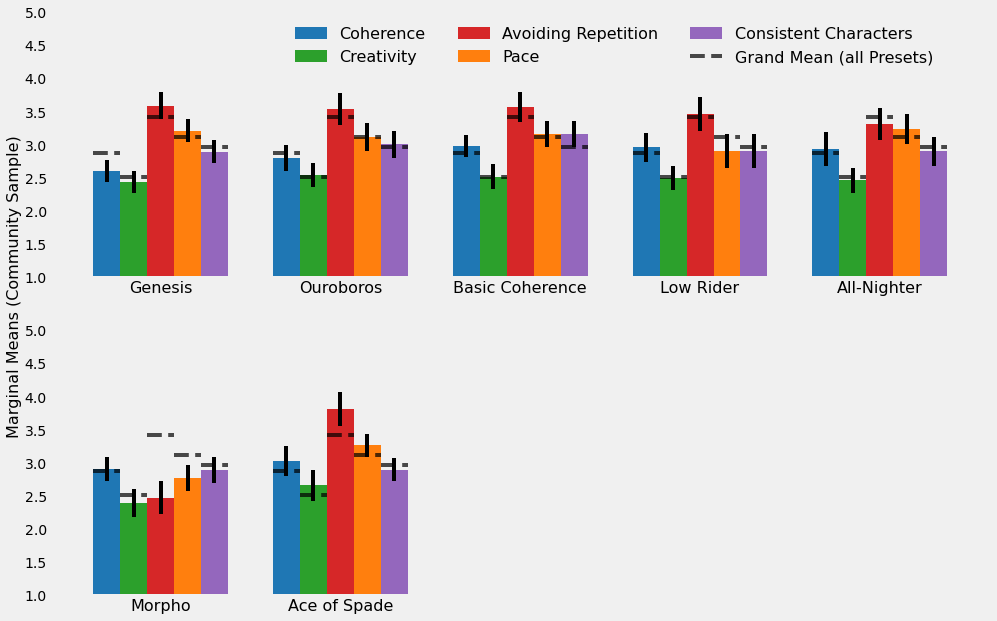

In [47]:
labels = ["Coherence", "Creativity",
          "Avoiding Repitition", "Pace", "Consistent Characters"]
presets_1 = ["Genesis", "Ouroboros",
             "Basic Coherence", "Low Rider", "All-Nighter"]
presets_2 = ["Morpho", "Ace of Spade"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(1, 5))
fig.text(0.04, 0.5, "Marginal Means (Community Sample)",
         va='center', rotation='vertical', fontsize=16)

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    marginal_means_dict = {outcome: [] for outcome in outcome_li}
    yerr_dict = {outcome: [] for outcome in outcome_li}

    prod_presets_outcomes = itertools.product(pre_li, outcome_li)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(
            params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
        yerr_dict[outcome].append(
            params_df.loc[preset, outcome + " 90% CI margin"])

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcome_li:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(x-0.3, marginal_means_dict["tss_coh"], width,
               yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

    cur_ax.bar(x-0.15, marginal_means_dict["tss_cre"], width,
               yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

    cur_ax.bar(x, marginal_means_dict["tss_avoid_rep"], width,
               yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

    cur_ax.bar(x+0.15, marginal_means_dict["tss_pac"], width,
               yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

    cur_ax.bar(x+0.3, marginal_means_dict["tss_conch"], width,
               yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

    outcome_i = 0
    pos = -0.375
    for outcome in outcome_li:
        grand_mean = params_df.loc["Intercept", outcome]
        for preset_i in range(0, n_presets):
            ax = cur_ax.plot([pos+preset_i, pos+width+preset_i],
                             [grand_mean, grand_mean], '--', color="black", alpha=0.7)
        if outcome_i == 0:
            ax[0].set_label("Grand Mean (all Presets)")
        outcome_i += 1
        pos += width

    handles, labels = cur_ax.get_legend_handles_labels()
    order = [1, 2, 3, 4, 5, 0]
    cur_ax.grid(False)

    i += 1

axes[0].legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
plt.show()

fig.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")

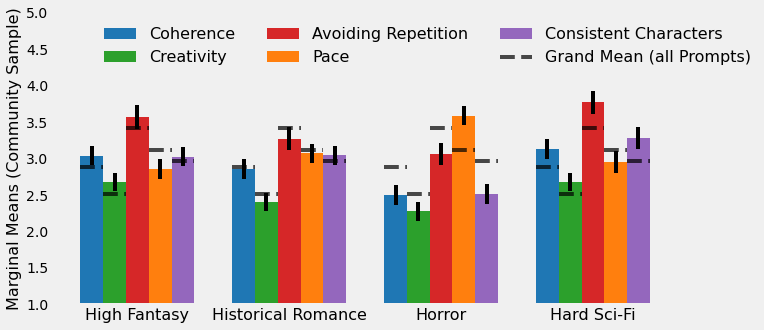

In [48]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

outcome_i = 0
pos = -0.375
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Prompts)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 5, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")

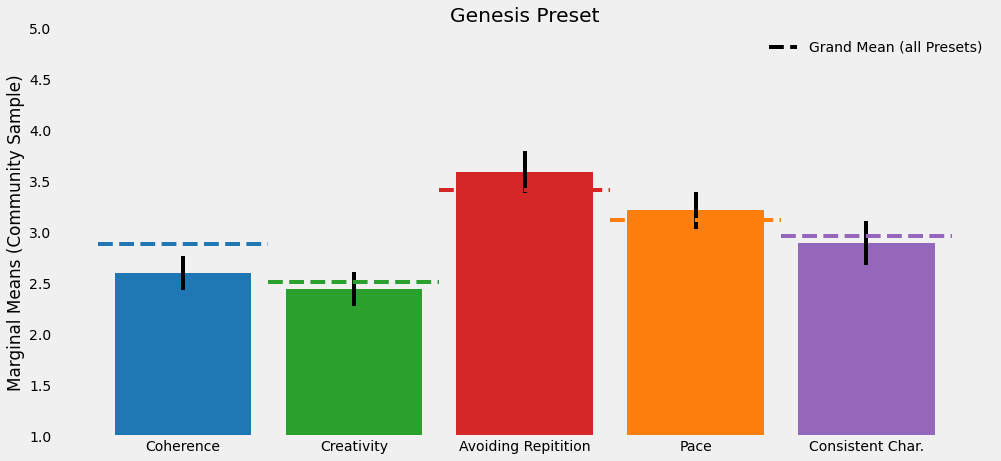

In [49]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:purple"]

for outcome in outcome_li:
    genesis_marginal_means.append(
        params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])


figure = plt.figure(figsize=(15, 7))

plt.bar(["Coherence", "Creativity", "Avoiding Repitition", "Pace", "Consistent Char."],
        genesis_marginal_means, yerr=genesis_yerr,
        color=colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean],
                  '--', color=colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

# Analyze Consistency of Story Aspects Across Presets & Prompts

In [50]:
for outcome in outcome_li:
    print(("_"*75) + "\n")
    print("\033[1m{}\033[0m".format(outcome))

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="preset_label", method="levene", alpha=0.1)
    print("Omnibus Test for homoscedasticity across presets")
    print(homo_res.round(3))

    if homo_res.iloc[0, 2] == False:
        print("\nVariances are not equal, doing posthoc tests")
        print(f"Average SD: {tss_no_out[outcome].std():.2f}")
        print("\nPresets with adjusted p-vals < .15 displayed below:")
        
        posthoc_dict = {}
        for preset in presets_li:
            data_preset = tss_no_out[tss_no_out["preset_label"]
                                     == preset][outcome].to_numpy()
            data_rest = tss_no_out[tss_no_out["preset_label"]
                                   != preset][outcome].to_numpy()
            posthoc_dict[preset] = pg.homoscedasticity(
                [data_preset, data_rest], method="levene", alpha=0.1)

        ps_li = []
        for dv in posthoc_dict:
            ps_li.append(posthoc_dict[dv].iloc[0, 1])
        adj_ps_li = fdrcorrection(ps_li, alpha=0.1)[1]

        i = 0
        for dv in posthoc_dict:
            posthoc_dict[dv].loc["levene", "sd"] = tss_no_out[tss_no_out["preset_label"] == dv][outcome].std()
            posthoc_dict[dv].loc["levene", "adj_p"] = adj_ps_li[i]
            if posthoc_dict[dv].loc["levene", "adj_p"] < 0.15:
                print(f"\n{dv}")
                print(posthoc_dict[dv].round(3))
            i += 1

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="prompt_label", method="levene", alpha=0.1)
    print("-"*75)
    print("\nOmnibus Test for homoscedasticity across prompts")
    print(f"{homo_res.round(3)}\n")

___________________________________________________________________________

tss_coh
Omnibus Test for homoscedasticity across presets
            W   pval  equal_var
levene  2.559  0.014      False

Variances are not equal, doing posthoc tests
Average SD: 0.84

Presets with adjusted p-vals < .15 displayed below:

All-Nighter
            W   pval  equal_var     sd  adj_p
levene  7.963  0.005      False  1.066   0.02

Basic Coherence
            W   pval  equal_var     sd  adj_p
levene  8.481  0.004      False  0.621   0.02
---------------------------------------------------------------------------

Omnibus Test for homoscedasticity across prompts
            W   pval  equal_var
levene  1.213  0.305       True

___________________________________________________________________________

tss_cre
Omnibus Test for homoscedasticity across presets
            W   pval  equal_var
levene  1.112  0.355       True
---------------------------------------------------------------------------

Omnibu

## Visualize Findings

In [51]:
def hist_over_groups(df, var, var_name, group_label, groups_li,
                     bins_n=10, xlim= (1,5), size=(15, 15),
                    plot_avg=True):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0
    
    if plot_avg:
        df[var].plot.hist(ax=axes[x], bins=bins_n)
        df[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - Average")
        plt.grid(False)
        x += 1
        
    for group in groups_li:
        df_group = df[df[group_label]==group]
        df_group[var].plot.hist(ax=axes[x], bins=bins_n)
        df_group[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - {group}")
        plt.grid(False)
        x += 1
        
def box_over_groups(df, var, var_name, group_label, groups_li,
                     ylim= (1,5), size=(15, 15),
                    plot_avg=True):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0
    
    if plot_avg:
        sns.boxplot(y=df[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - Average")
        axes[x].grid(False)
        x += 1
        
    for group in groups_li:
        df_group = df[df[group_label]==group]
        sns.boxplot(y=df_group[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - {group}")
        axes[x].grid(False)
        x += 1

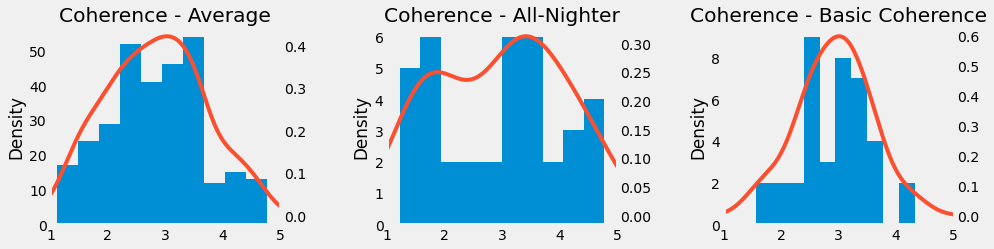

In [52]:
hist_over_groups(tss_no_out, "tss_coh", "Coherence",
                 "preset_label", ["All-Nighter", "Basic Coherence"],
                size=(15,5))

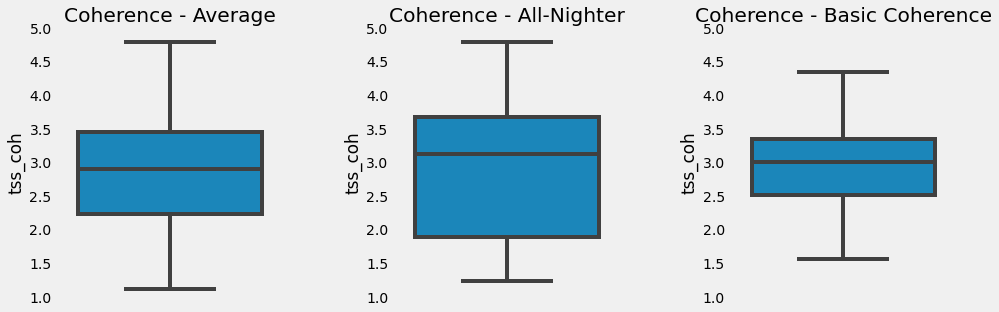

In [53]:
box_over_groups(tss_no_out, "tss_coh", "Coherence",
                 "preset_label", ["All-Nighter", "Basic Coherence"],
                size=(15,6))

In [ ]:
# hist_over_groups(tss_no_out, "tss_pac", "Coherence",
#                  "preset_label", ["Low Rider", "Ace of Spade", "Morpho"],
#                 size=(15,5), bins_n=7)

In [ ]:
# box_over_groups(tss_no_out, "tss_pac", "Pace",
#                  "preset_label", ["Low Rider", "Ace of Spade", "Morpho"],
#                 size=(15,6))

In [54]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre", "tss_conch",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2"]].corr(method="kendall")

,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_conch,tss_cre_4,tss_qua_1,tss_qua_2
tss_coh,1.000000,0.095902,-0.046686,0.220102,0.344851,0.072502,0.325738,0.335995
tss_avoid_rep,0.095902,1.000000,0.132473,0.127216,0.157068,0.124031,0.188180,0.197627
tss_pac,-0.046686,0.132473,1.000000,0.154701,0.023367,0.266901,0.169562,0.089904
tss_cre,0.220102,0.127216,0.154701,1.000000,0.178853,0.422508,0.487196,0.620529
tss_conch,0.344851,0.157068,0.023367,0.178853,1.000000,0.177215,0.223948,0.267084
tss_cre_4,0.072502,0.124031,0.266901,0.422508,0.177215,1.000000,0.378144,0.295566
tss_qua_1,0.325738,0.188180,0.169562,0.487196,0.223948,0.378144,1.000000,0.516543
tss_qua_2,0.335995,0.197627,0.089904,0.620529,0.267084,0.295566,0.516543,1.000000


In [ ]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

In [55]:
tss_no_out["qual_2_agree+"] = tss_no_out["tss_qua_2"].apply(
    lambda x: 1 if x >= 4 else 0)
tss_no_out["qual_1_agree+"] = tss_no_out["tss_qua_1"].apply(
    lambda x: 1 if x >= 4 else 0)

In [56]:
# Center preds and prepare polynomial arrays
unc_pred_names_li = ["word_count", "tss_coh",
                     "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
cent_pred_names_li = []

# Defining predictors for models
for pred in unc_pred_names_li:
    cent_pred = pred + "_cent"
    tss_no_out[cent_pred] = tss_no_out[pred].apply(
        lambda x: x-tss_no_out[pred].mean())  # centering
    cent_pred_names_li.append(cent_pred)

lin_pred_data = tss_no_out[cent_pred_names_li].to_numpy()

poly_lin = polyfeat(interaction_only=True, include_bias=False)
lin_int_pred_data = poly_lin.fit_transform(lin_pred_data)

quad_pred_data = np.hstack((lin_pred_data, lin_pred_data**2))
cub_pred_data = np.hstack((lin_pred_data, lin_pred_data**2, lin_pred_data**3))
quart_pred_data = np.hstack(
    (lin_pred_data, lin_pred_data**2, lin_pred_data**3, lin_pred_data**4))

# Setting up k-fold cross validation
kf = KFold(10, shuffle=True, random_state=42)

log_model = logreg(max_iter=1000)

# setup list of model names with predictor arrays
poly_preds_li = [("linear", lin_pred_data), ("linear with interactions", lin_int_pred_data),
                 ("quadratic", quad_pred_data),
                 ("cubic", cub_pred_data), ("quartic", quart_pred_data)]

qua_li = ["qual_1_agree+", "qual_2_agree+"]

for qual_measure in qua_li:
    for poly_pred in poly_preds_li:
        y = tss_no_out[qual_measure]
        current_pred = poly_pred[1]
        current_model_name = poly_pred[0]
        cross_val = cross_validate(log_model, current_pred, y,
                                   scoring=["neg_log_loss"], cv=kf)
        # get negative loss scores, throw out nans if we got some
        nll = cross_val["test_neg_log_loss"]
        nll = nll[~np.isnan(nll)]
        avg_nll = np.mean(nll)
        print("Model performance for {} model predicting good or better output for {}:".format(
            current_model_name, qual_measure))
        print("negative log loss:{:.4f}\n".format(avg_nll))
    print("")

    # linear without interactions performs best

Model performance for linear model predicting good or better output for qual_1_agree+:
negative log loss:-0.5012

Model performance for linear with interactions model predicting good or better output for qual_1_agree+:
negative log loss:-0.5279

Model performance for quadratic model predicting good or better output for qual_1_agree+:
negative log loss:-0.5163

Model performance for cubic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6968

Model performance for quartic model predicting good or better output for qual_1_agree+:
negative log loss:-0.7066


Model performance for linear model predicting good or better output for qual_2_agree+:
negative log loss:-0.2655

Model performance for linear with interactions model predicting good or better output for qual_2_agree+:
negative log loss:-0.3064

Model performance for quadratic model predicting good or better output for qual_2_agree+:
negative log loss:-0.3125

Model performance for cubic model predicting 

In [57]:
log_reg_q1 = smf.logit(("Q('qual_1_agree+') ~ word_count_cent + tss_coh_cent" +
                        "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                        "+ tss_conch_cent" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()
log_reg_q2 = smf.logit(("Q('qual_2_agree+') ~ word_count_cent + tss_coh_cent" +
                        "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                        "+ tss_conch_cent" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()

print("\n\033[1mQuality Item 1 (Enjoyment)\033[0m")
print(log_reg_q1.summary())
print("\n\033[1mQuality Item 2 (High Quality)\033[0m")
print(log_reg_q2.summary())

Optimization terminated successfully.
         Current function value: 0.474839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.239742
         Iterations 8

Quality Item 1 (Enjoyment)
                           Logit Regression Results                           
Dep. Variable:     Q('qual_1_agree+')   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Mon, 11 Apr 2022   Pseudo R-squ.:                  0.2829
Time:                        14:20:18   Log-Likelihood:                -143.88
converged:                       True   LL-Null:                       -200.64
Covariance Type:            nonrobust   LLR p-value:                 1.694e-21
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [58]:
logreg_li = [("Quality 1 (Enjoyment)", log_reg_q1),
             ("Quality 2 (High Quality)", log_reg_q2)]

for log_reg in logreg_li:
    print(f"Predictions & Performance for {log_reg[0]}")
    pred_table = log_reg[1].pred_table()

    # read out table values
    tn = pred_table[0, 0]
    tp = pred_table[1, 1]
    fn = pred_table[1, 0]
    fp = pred_table[0, 1]
    total = np.sum(pred_table)

    # Observed Probability
    obs_p = (tp + fn) / total

    # predicted prob
    pred_prob = (tp + fp) / total

    # Accuracy: Correct classification over all cases
    acc = (tp + tn) / total

    # Precision: Accuracy for data predicted to be positive
    prec = tp / (tp+fp)
    # Recall: Accuracy for positive (enjoyable/high quality) data
    rec = tp / (tp+fn)

    odds_ratio = np.exp(log_reg[1].params)

    print(f"Observed Probability: {obs_p:.2f}\n"
          f"Predicted Probability: {pred_prob:.2f}\n\n"
          f"Model Performance\n"
          f"Accuracy: {acc:.2f}\n"
          f"Precision: {prec:.2f}\n"
          f"Recall: {rec:.2f}\n"
          f"\nOdds Ratio:\n{odds_ratio}\n")

Predictions & Performance for Quality 1 (Enjoyment)
Observed Probability: 0.38
Predicted Probability: 0.35

Model Performance
Accuracy: 0.76
Precision: 0.70
Recall: 0.64

Odds Ratio:
Intercept                           0.398396
C(sample, Treatment(0))[T.Panel]    1.477767
word_count_cent                     1.002961
tss_coh_cent                        1.883593
tss_cre_cent                        3.936315
tss_avoid_rep_cent                  1.478488
tss_pac_cent                        1.580083
tss_conch_cent                      1.178467
dtype: float64

Predictions & Performance for Quality 2 (High Quality)
Observed Probability: 0.17
Predicted Probability: 0.13

Model Performance
Accuracy: 0.89
Precision: 0.76
Recall: 0.56

Odds Ratio:
Intercept                            0.042472
C(sample, Treatment(0))[T.Panel]     1.121023
word_count_cent                      1.000593
tss_coh_cent                         1.579037
tss_cre_cent                        19.455168
tss_avoid_rep_cent       

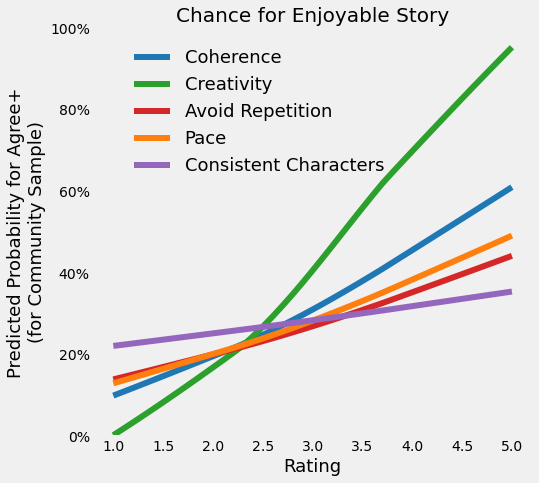

In [61]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent", "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Creativity", "tss_cre", "tab:green"),
             ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
             ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns={"plot_values": var_full}, inplace=True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - \
        tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 1"] = log_reg_q1.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 1",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color=color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+\n(for Community Sample)")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon=False, bbox_to_anchor=(.7, .6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for Enjoyable Story", fontsize=20)
plt.savefig("graphs/logreg_qual_1.png", bbox_inches="tight")
plt.show()

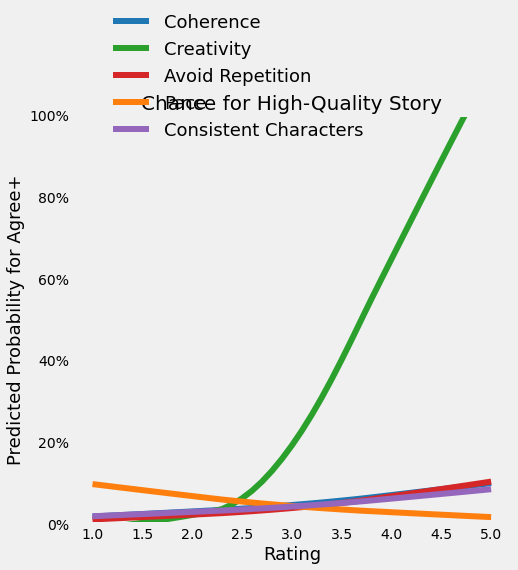

In [62]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent",
                  "tss_conch_cent",
                  "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh", "tab:blue"),
             ("Creativity", "tss_cre", "tab:green"),
             ("Avoid Repetition", "tss_avoid_rep", "tab:red"),
             ("Pace", "tss_pac", "tab:orange"),
             ("Consistent Characters", "tss_conch", "tab:purple")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    color = var[2]
    pred_df.rename(columns={"plot_values": var_full}, inplace=True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - \
        tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 2"] = log_reg_q2.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 2",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True, color=color)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon=False, bbox_to_anchor=(.7, .9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for High-Quality Story", fontsize=20)
plt.savefig("graphs/logreg_qual_2.png", bbox_inches="tight")
plt.show()

In [63]:
log_reg_q1 = smf.logit(("Q('qual_1_agree+') ~  C(preset_label, Sum) + C(prompt_label, Sum)" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()
log_reg_q2 = smf.logit(("Q('qual_2_agree+') ~ C(preset_label, Sum) + C(prompt_label, Sum)" +
                        "+ C(sample, Treatment(0))"),
                       data=tss_no_out).fit()

print("\n\033[1mQuality Item 1 (Enjoyment)\033[0m")
print(log_reg_q1.summary())
print("\n\033[1mQuality Item 2 (High Quality)\033[0m")
print(log_reg_q2.summary())

Optimization terminated successfully.
         Current function value: 0.629333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421357
         Iterations 7

Quality Item 1 (Enjoyment)
                           Logit Regression Results                           
Dep. Variable:     Q('qual_1_agree+')   No. Observations:                  303
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                           11
Date:                Mon, 11 Apr 2022   Pseudo R-squ.:                 0.04962
Time:                        14:23:37   Log-Likelihood:                -190.69
converged:                       True   LL-Null:                       -200.64
Covariance Type:            nonrobust   LLR p-value:                   0.04655
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

<AxesSubplot:xlabel='tss_qua_1', ylabel='preset_label'>

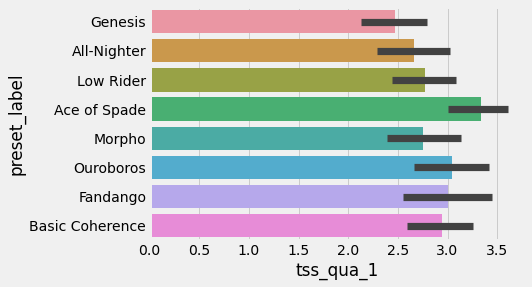

In [64]:
# qual = tss_no_out.groupby('preset_label').mean(
# )[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

# figure = plt.figure(figsize=(10, 5))
sns.barplot(x = "tss_qua_1", y = "preset_label", data = tss_no_out)
#plt.bar(qual.index, qual["tss_qua_1"])
#plt.xticks(rotation=45)

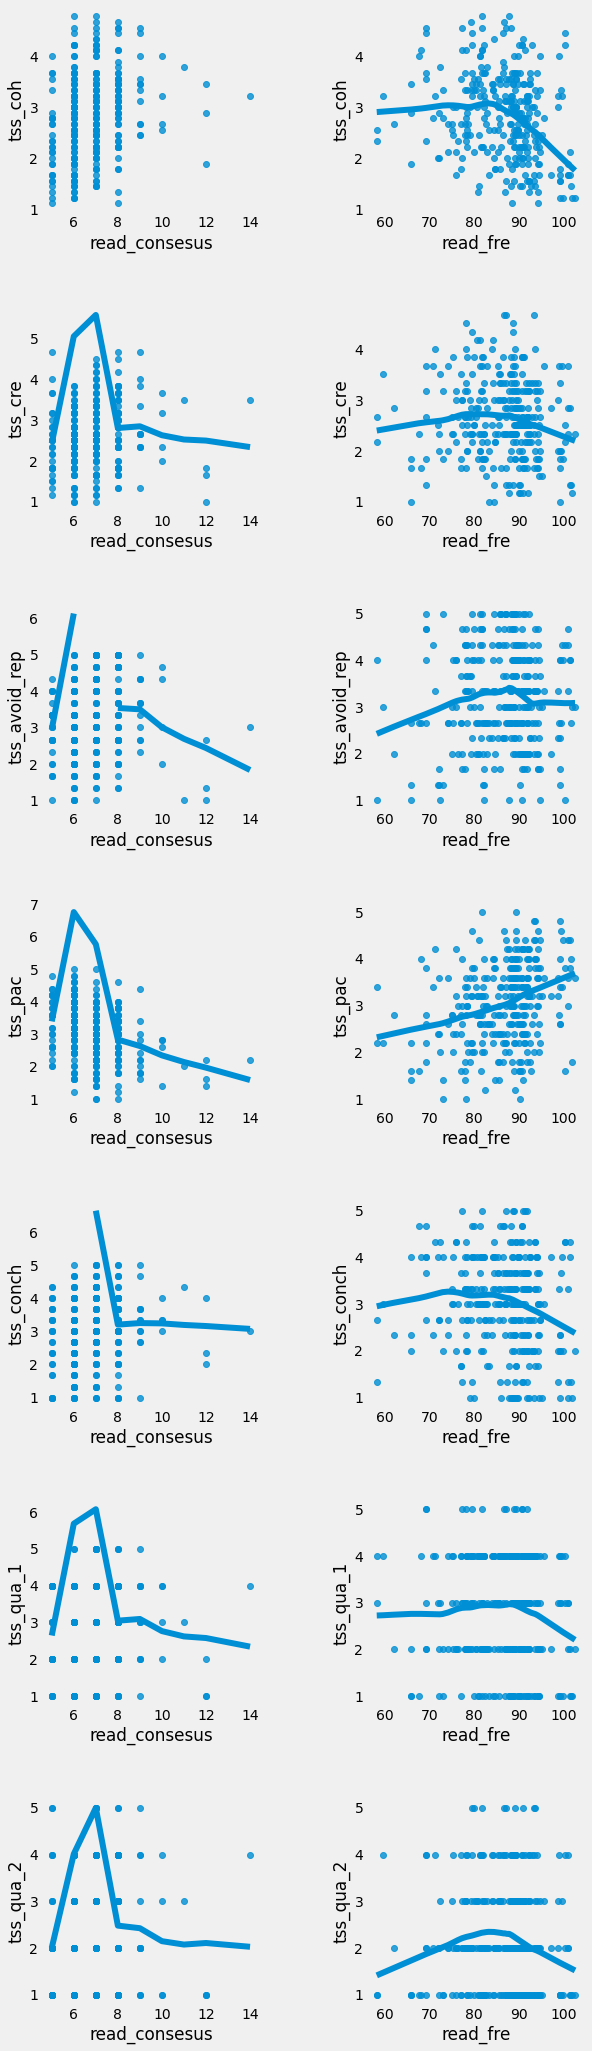

In [65]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()

In [66]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["read_cent"] = tss_df["read_consesus"].apply(
    lambda x: x-tss_df["read_consesus"].mean())  # centering

tss_df["read_cent**2"] = tss_df["read_cent"]*tss_df["read_cent"]
tss_df["read_cent**3"] = tss_df["read_cent"]**3
tss_df["read_cent**4"] = tss_df["read_cent"]**4
tss_df["read_cent**5"] = tss_df["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep",
              "tss_pac", "tss_conch", "tss_qua_1", "tss_qua_2"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

Model performance for linear model predicting tss_coh:
r-square: 0.0114    RMSE: 0.8193
Model performance for quadratic model predicting tss_coh:
r-square: 0.0264    RMSE: 0.8127
Model performance for cubic model predicting tss_coh:
r-square: 0.0219    RMSE: 0.8147
Model performance for quartic model predicting tss_coh:
r-square: -0.0518    RMSE: 0.8436
Model performance for quintic model predicting tss_coh:
r-square: -0.1172    RMSE: 0.8647

Model performance for linear model predicting tss_cre:
r-square: -0.0086    RMSE: 0.7681
Model performance for quadratic model predicting tss_cre:
r-square: -0.0437    RMSE: 0.7752
Model performance for cubic model predicting tss_cre:
r-square: -0.1875    RMSE: 0.8048
Model performance for quartic model predicting tss_cre:
r-square: -0.3445    RMSE: 0.8279
Model performance for quintic model predicting tss_cre:
r-square: -6.7936    RMSE: 1.1880

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0486    RMSE: 1.0566
Model pe

In [67]:
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                               "All-Nighter", "Morpho", "Ace of Spade"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_conch 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p",
                               "tss_conch adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_conch", "Consistent Characters")

In [68]:
marg_means_df

,Coherence,Creativity,Avoiding Repitition,Pace,Consistent Characters,Coherence 90% CI margin,Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Consistent Characters 90% CI margin,Coherence adj_p,Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p,Consistent Characters adj_p
Grand Mean,2.879407,2.508762,3.417794,3.116637,2.964774,0.118454,0.098181,0.141219,0.112246,0.152501,NaN,NaN,NaN,NaN,NaN
Genesis,2.600282,2.441580,3.589478,3.212763,2.894707,0.171184,0.165979,0.203326,0.179020,0.216564,0.058543,0.941757,4.396525e-01,0.502826,0.783071
Ouroboros,2.798362,2.546505,3.533941,3.111286,3.004755,0.197596,0.180234,0.240146,0.208025,0.238863,0.776168,0.941757,5.193215e-01,0.966252,0.783071
Basic Coherence,2.980562,2.517237,3.567366,3.163198,3.159637,0.167202,0.190797,0.228381,0.198491,0.246335,0.776168,0.941757,4.951263e-01,0.799558,0.783071
Low Rider,2.959627,2.490235,3.463986,2.902325,2.902355,0.221392,0.181457,0.259441,0.257807,0.266754,0.776168,0.941757,7.696330e-01,0.457378,0.783071
All-Nighter,2.937949,2.461066,3.308015,3.237262,2.898008,0.253889,0.190451,0.241377,0.222380,0.283820,0.776168,0.941757,5.193215e-01,0.502826,0.783071
Morpho,2.910493,2.392710,2.469654,2.765334,2.895087,0.179840,0.206993,0.249890,0.196297,0.233704,0.776168,0.941757,3.479094e-09,0.025944,0.783071
Ace of Spade,3.021498,2.657072,3.805445,3.261130,2.894080,0.226534,0.226946,0.256942,0.171514,0.285575,0.776168,0.941757,5.231733e-02,0.457378,0.783071


In [69]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)

In [ ]:
mask = ((tss_no_out["preset_label"] == "Morpho") &
        (tss_no_out["tss_coh"] > 2.55) &
        (tss_no_out["tss_avoid_rep"] > 2.21) &
        (tss_no_out["tss_avoid_rep"] < 2.70) &
        (tss_no_out["sample"] == "Community")
        )

tss_no_out[mask]

In [ ]:
print(tss_no_out.loc[35, outcome_li])
print(tss_no_out.loc[35, "full_story"])

In [ ]:
print(tss_no_out.loc[130, outcome_li])
print(tss_no_out.loc[130, "full_story"])